# Machine Learning Project: Employee Turnover Analytics
Chandni Kazi 
03/30/24

In [130]:
import numpy as np 
import pandas as pd
import openpyxl
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score

In [131]:
#Read in the dataset
df = pd.read_excel("1688640705_hr_comma_sep.xlsx")
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [132]:
#Rename "sales" to "Department"
df.rename(columns={'sales':'Department',
                   'average_montly_hours':'average_monthly_hours'},inplace=True)
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department', 'salary'],
      dtype='object')

Perform data quality checks

In [133]:
#Shape of data frame
print(f'the data frame has {df.shape[1]} features and {df.shape[0]} rows')

the data frame has 10 features and 14999 rows


In [134]:
#variable information 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_monthly_hours  14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


### 1. Perform data quality check by checking for missing values if any. 

In [135]:
#any missing values
df.isna().sum()
print(f'There are {df.isna().sum().sum()} missing values across the entire dataset.')


There are 0 missing values across the entire dataset.


Text(0.5, 1.0, 'Missing values heatmap')

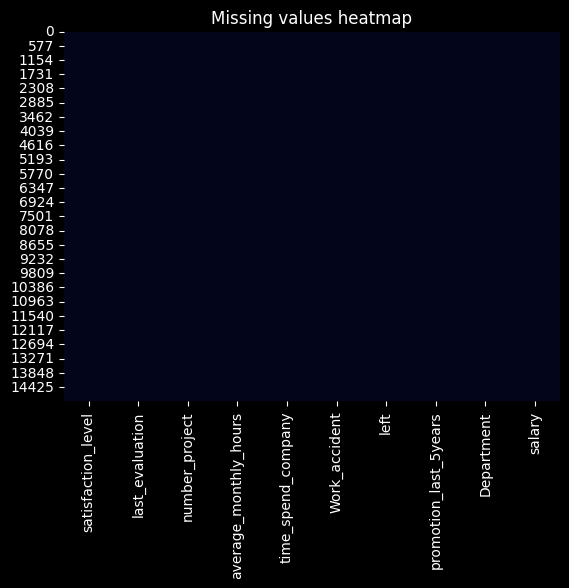

In [136]:
sns.heatmap(df.isna(),cbar=False).set_title("Missing values heatmap")
#There are no missing values

In [137]:
#summary of numerical data
df.describe()


,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [138]:
#Summary of categorial data 
def colvals(dataframe):
    """
    loop through the columns fo a dataframe and output the value counts for each column.
    Args: the input dataframe
    Returns: A dictionary where keys are column names and values are the value counts
    """
    value_counts_dict = {}
    for col in dataframe.columns:
        if dataframe[col].dtype =='object':
            value_counts_dict[col]=dataframe[col].value_counts()

    return value_counts_dict

value_results = colvals(df)

for col, value_counts in value_results.items(): 
    print(f"Value counts for column '{col}':\n{value_counts}\n ")

Value counts for column 'Department':
Department
sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: count, dtype: int64
 
Value counts for column 'salary':
salary
low       7316
medium    6446
high      1237
Name: count, dtype: int64
 


### 2.1 Draw a heatmap of the correlation matrix between all numerical features/columns in the data

Chandni's Observations: 
- There is a strong correlation between 'last evaluation' and 'number of projects'as well as with 'average monthly hours.'
- There is a moderately strong correlation between 'number of projects' and 'average monthly hours'
- All other correlations are weak correlations 

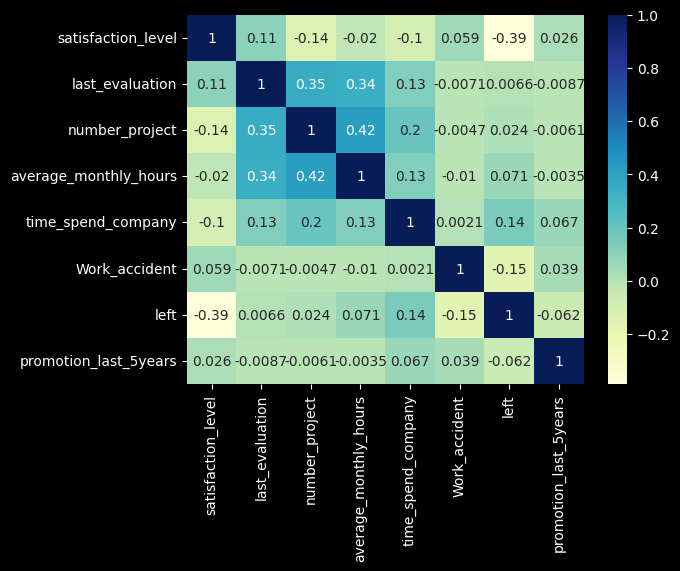

In [139]:
#print(df.corr(numeric_only=True))
heatmapplot = sns.heatmap(df.corr(numeric_only=True),cmap="YlGnBu",annot=True)

### 2.2 Draw the distribution plot of 
- Employee satisfaction (satisfaction_level)
- Employee evaluation (last_evaluation)
- Employee average monthly hours (average_monthly_hours)

Chandni's Observations: 
- Although 'employee satisfaction' mean and mode are equivalent, the distribution has a non-normal pattern (two peaks). Many employees have a very low employee satisfaction and then the rest of graph presents somewhere between uniform and normal distribution. 
- Although 'employee evaluation' mean and mode and equivalent, the distribution has a non-normal pattern. 
- Although 'employee average monthly hours' mean and mode and equivalent, the distribution has a non-normal pattern (two peaks).
- Overall, all three variables have imbalanced data distributions.  

[Text(0.5, 1.0, 'Employee Average Monthly Hours')]

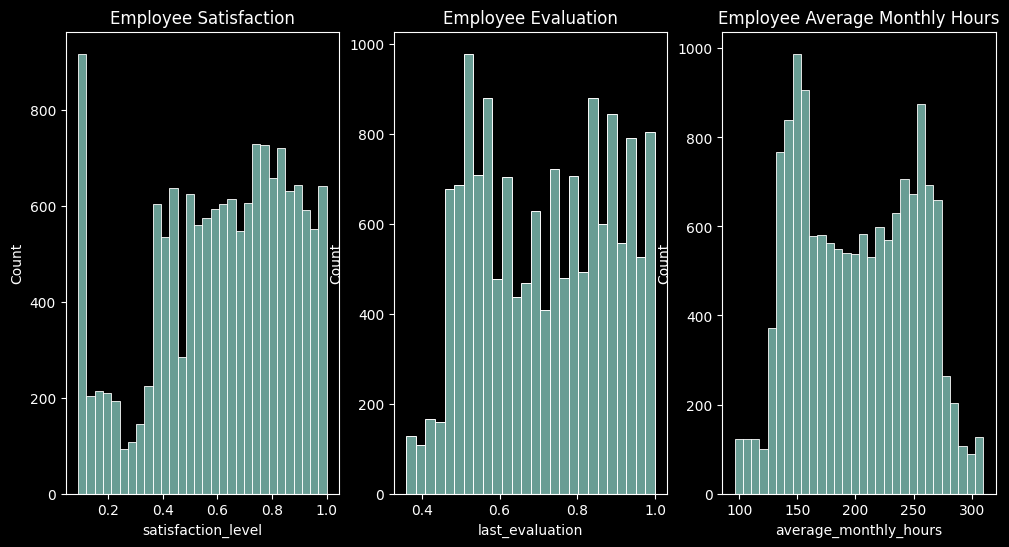

In [140]:
fig,axs = plt.subplots(ncols=3,figsize=(12,6))
sns.histplot(df,x='satisfaction_level',ax=axs[0]).set(title='Employee Satisfaction')
sns.histplot(df,x='last_evaluation',ax=axs[1]).set(title='Employee Evaluation')
sns.histplot(df,x='average_monthly_hours',ax=axs[2]).set(title="Employee Average Monthly Hours")


### 2.3 Draw the bar plot of Employee Project Count of both employees who left and who stayed in the organization (use column number_project and hue column left) and give your inferences from the plot

Chandni's Observation: 
The bar graph below shows that the average number of projects is slightly higher among employees that left the company than employees that stayed. This visual difference is likely not statistically significant. 

<Axes: ylabel='number_project'>

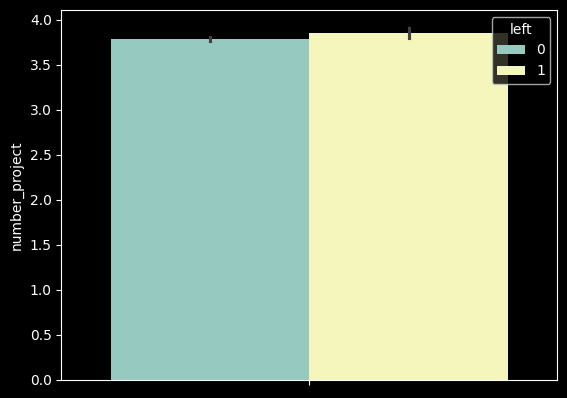

In [141]:
sns.barplot(df,y='number_project',hue='left')

### 3. Perform clustering of employees who left based on their satisfaction and evalution. 
3.1 Choose columns satisfaction_level, last_evaluation and left.
3.2 Do KMeans clustering of employees who left the company into 3 clusters. 
3.3 Based on the satisfaction and evaluation factors, give your thoughts on the employee clusters

Chandni's Observations: 
- The following look like 3 clusters of employees that left the company: 
    1. Employees with extremely low satisfaction levels but very good performance evaluations 
    2. Employees with low-to-moderate satisfaction levels but low performers overall 
    3. Employees with extremely high satisfaction levels and great evaluation scores. 
  

In [142]:
#only employees that left the company: 3,571 employees left the company
df_left = df[df['left']==1].iloc[0:3571,0:7]
df_left.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left
0,0.38,0.53,2,157,3,0,1
1,0.80,0.86,5,262,6,0,1
2,0.11,0.88,7,272,4,0,1
3,0.72,0.87,5,223,5,0,1
4,0.37,0.52,2,159,3,0,1


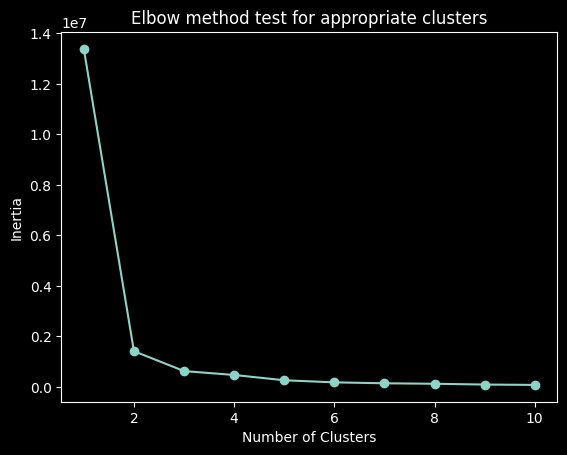

In [143]:
#Check number of appropriate clusters 
inertias = []

for i in range(1,11): 
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_left)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11),inertias,marker='o')
plt.title("Elbow method test for appropriate clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()



In [144]:
km = KMeans(n_clusters=3)
df_left["cluster"] = km.fit_predict(df_left[['satisfaction_level','last_evaluation']]) #giving clusters based on attack and defense 
df_left.head() #new column added for cluster

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,cluster
0,0.38,0.53,2,157,3,0,1,0
1,0.80,0.86,5,262,6,0,1,1
2,0.11,0.88,7,272,4,0,1,2
3,0.72,0.87,5,223,5,0,1,1
4,0.37,0.52,2,159,3,0,1,0


In [145]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_left)
#add centroids to the graph 
centroids = kmeans.cluster_centers_
print(centroids)

[[4.15914894e-01 5.30613982e-01 2.17872340e+00 1.44832219e+02
  3.07173252e+00 4.74164134e-02 1.00000000e+00 7.53799392e-02]
 [6.10000000e-01 8.89191111e-01 4.93688889e+00 2.43640889e+02
  4.77866667e+00 5.33333333e-02 1.00000000e+00 1.21244444e+00]
 [2.51136080e-01 8.62896380e-01 5.78027466e+00 2.85079900e+02
  4.26217228e+00 3.87016230e-02 1.00000000e+00 1.71910112e+00]]


In [146]:
cent_x = [i[0] for i in centroids] #gives every results in the x coordinates 
cent_y = [i[1] for i in centroids] #gives every results in the x coordinates 
print(cent_x)
print(cent_y)

[0.4159148936170213, 0.61, 0.2511360799001249]
[0.5306139817629179, 0.8891911111111112, 0.8628963795255931]


In [147]:
#map the centroid to the cluster in the dataset based on index positions 
df_left['centx'] = df_left['cluster'].map({
    0:cent_x[0],
    1:cent_x[1],
    2:cent_x[2]
})

df_left['centy'] = df_left['cluster'].map({
    0:cent_y[0],
    1:cent_y[1],
    2:cent_y[2]
})

df_left.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,cluster,centx,centy
0,0.38,0.53,2,157,3,0,1,0,0.415915,0.530614
1,0.80,0.86,5,262,6,0,1,1,0.610000,0.889191
2,0.11,0.88,7,272,4,0,1,2,0.251136,0.862896
3,0.72,0.87,5,223,5,0,1,1,0.610000,0.889191
4,0.37,0.52,2,159,3,0,1,0,0.415915,0.530614


In [148]:
my_cust_col = ['#E4080A','#FFDE59','#0E05FC']

df_left['clust_col'] = df_left['cluster'].map({
    0:my_cust_col[0],
    1:my_cust_col[1],
    2:my_cust_col[2]
})

df_left.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,left,cluster,centx,centy,clust_col
0,0.38,0.53,2,157,3,0,1,0,0.415915,0.530614,#E4080A
1,0.80,0.86,5,262,6,0,1,1,0.610000,0.889191,#FFDE59
2,0.11,0.88,7,272,4,0,1,2,0.251136,0.862896,#0E05FC
3,0.72,0.87,5,223,5,0,1,1,0.610000,0.889191,#FFDE59
4,0.37,0.52,2,159,3,0,1,0,0.415915,0.530614,#E4080A


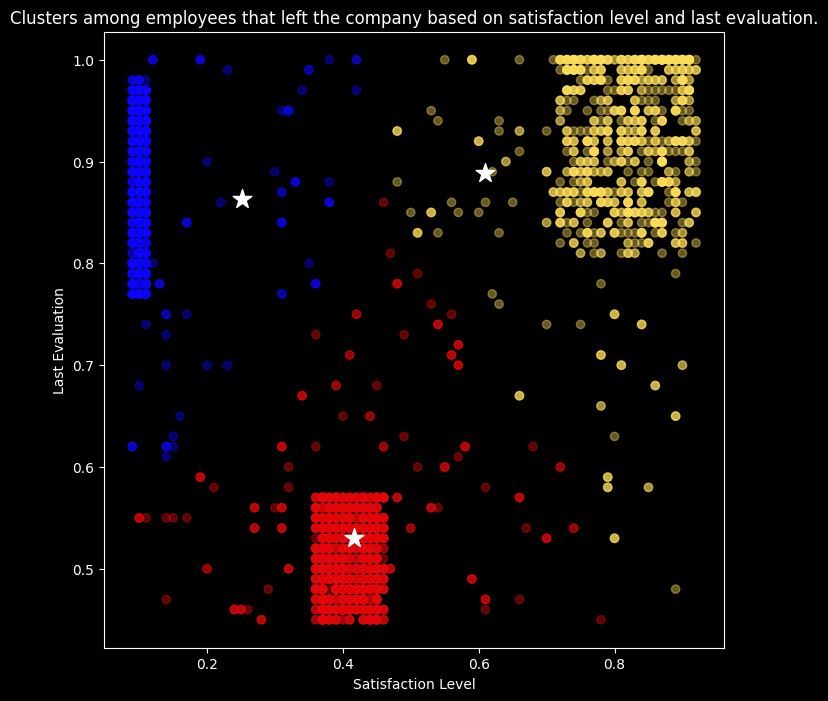

In [149]:
plt.style.use('dark_background')
plt.figure(figsize=(8,8))
plt.scatter(df_left['satisfaction_level'],df_left['last_evaluation'],c=df_left['clust_col'],alpha=0.4)
plt.scatter(cent_x,cent_y,marker='*',s=200,c='white')
plt.title("Clusters among employees that left the company based on satisfaction level and last evaluation.")
plt.xlabel("Satisfaction Level")
plt.ylabel("Last Evaluation")
plt.show()

- We can see there are three clusters, but there is a lot of noise. 
    - Red cluster = great workers with low satisfaction levels. These are high performers who likely left due to poor working conditions. Regrettable turnover
    - Yellow cluster =  employees who were coasting but didn't do great work for the company. Non-regrettable turnover 
    - Blue cluster = great workers who had high satisfaction, but they still left the company. This is regrettable turnover. 

Next steps would be to analyze the characteristics of the yellow and purple clusters to understand why these high performers are leaving, and can the company do anything to prevent their leaving. 

left
0    0.761917
1    0.238083
Name: proportion, dtype: float64


<Axes: xlabel='left'>

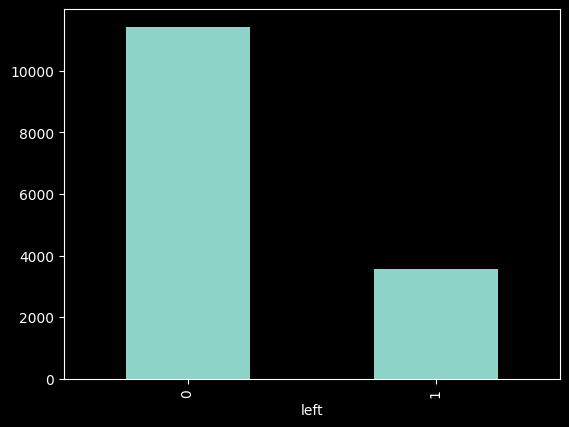

In [150]:
print(df["left"].value_counts(normalize=True))
df['left'].value_counts().plot(kind='bar')

Chandni's Observations: the 'left' outcome variable is imbalanced. Use resampling techniques to balance data for better ML outcomes 

In [151]:
#apply get_dummies to categorical data
df2 = pd.get_dummies(df,columns=['Department','salary'],dtype=int)
print(df2.columns)
print("")
print(df2.info())

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_monthly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'Department_IT', 'Department_RandD',
       'Department_accounting', 'Department_hr', 'Department_management',
       'Department_marketing', 'Department_product_mng', 'Department_sales',
       'Department_support', 'Department_technical', 'salary_high',
       'salary_low', 'salary_medium'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   satisfaction_level      14999 non-null  float64
 1   last_evaluation         14999 non-null  float64
 2   number_project          14999 non-null  int64  
 3   average_monthly_hours   14999 non-null  int64  
 4   time_spend_company      14999 non-null  int64  
 5   Work_accident       

left
1    0.5
0    0.5
Name: proportion, dtype: float64


<Axes: xlabel='left'>

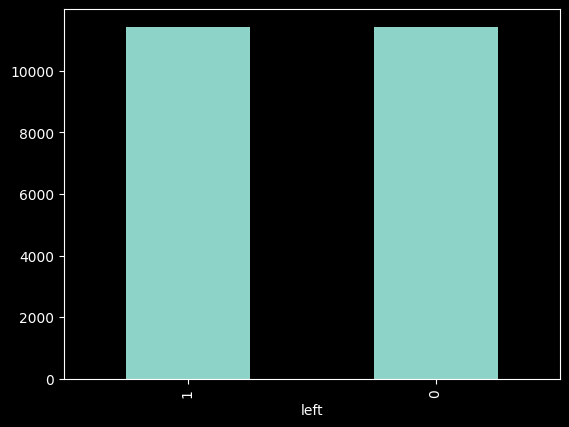

In [152]:
#split the data into outcome and features + use SMOTE to resample 
x = df2.drop("left",axis=1)
y = df2['left']

sm = SMOTE()
x_resm,y_resm = sm.fit_resample(x,y)
print(y_resm.value_counts(normalize=True))
y_resm.value_counts().plot(kind='bar')


In [153]:
#Split into train and test datasets 
x_train,x_test,y_train,y_test = train_test_split(x_resm,y_resm,test_size=.2,random_state=123)

5. Perform 5-fold cross-validation model training and evaluate performance. 
    
    5.1. Train logistic regression model and apply a 5-fold CV and plot the classification report 
    
    5.2. Train a random forest classifier model and apply the 5-fold CV and plot the classification report 
    
    5.3 Train a gradient boosting classifier model and apply the 5-fold CV and plot the classification report

6. Identify the best model and justify the evaluation metrics used - RANDOM FOREST
 
    6.1. Find the ROC/AUC for each model and plot the ROC curve 
    
    6.2. Find the confusion matrix for each of the models 
   
    6.3 From the confusion matrix, explain which metric needs to be used-Recall or precision? 
    
7. Suggest various retention strategies for targeted employees - SEE RANDOM FOREST SECTION 
    
    7.1. Using the best model, predict the probability of employee turnover in the test data
    
    7.2. Basedo n the below probability score range, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone. 
        
        - Safe Zone (Green) (Score < 20%)
        - Low Risk Zone (Yellow) (20% < Score < 60%)
        - Medium Risk Zone (Orange) (60% < Score < 90%)
        - High Risk Zone (Red) (Score > 90%)

In [154]:
kfolds = KFold(n_splits=5) #5-fold CV  

### Logistic regression

In [155]:
logr = LogisticRegression(max_iter=10000)
logr.fit(x_train,y_train)
y_pred = logr.predict(x_test)

In [156]:
results_log = cross_val_score(logr,x,y,cv=kfolds)
results_log.mean() #this is the average score of the model performance  


0.7319034789374237

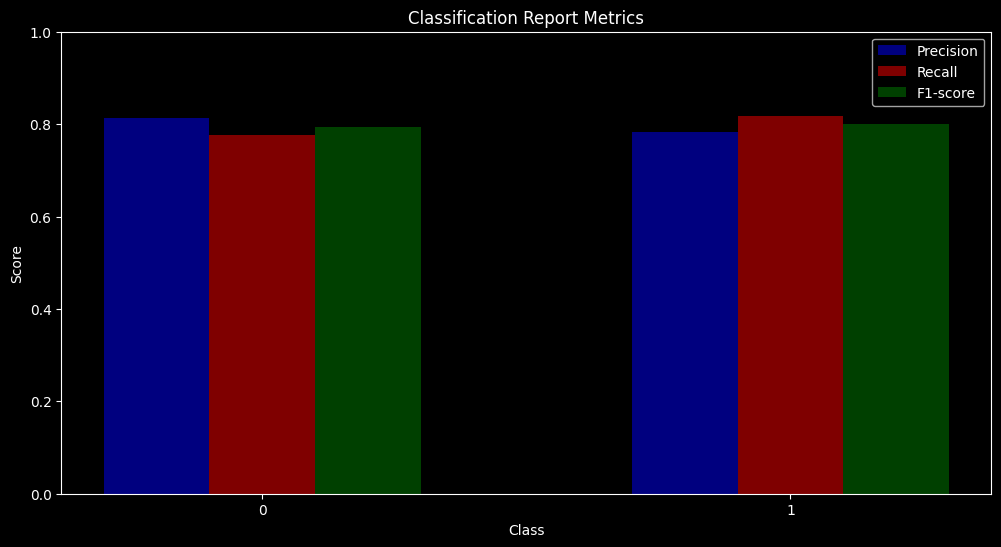

In [157]:
report = classification_report(y_test,y_pred,output_dict=True)
# Parse values from the classification report
class_names = [str(x) for x in range(len(report) - 3)]  # Extract class names from report
metrics = ['precision', 'recall', 'f1-score', 'support']

# Initialize lists to store metric values
precision = []
recall = []
f1_score = []
support = []

for class_name in class_names:
    precision.append(report[class_name]['precision'])
    recall.append(report[class_name]['recall'])
    f1_score.append(report[class_name]['f1-score'])
    support.append(report[class_name]['support'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(class_names))

# Bar plot for precision
ax.bar(index, precision, bar_width, color='b', alpha=0.5, label='Precision')
# Bar plot for recall
ax.bar(index + bar_width, recall, bar_width, color='r', alpha=0.5, label='Recall')
# Bar plot for F1-score
ax.bar(index + 2*bar_width, f1_score, bar_width, color='g', alpha=0.5, label='F1-score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_ylim(0.0,1.0)
ax.set_title('Classification Report Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()

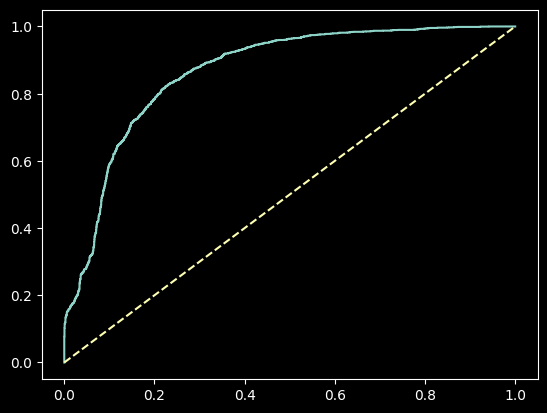

In [158]:
y_predproba = logr.predict_proba(x_test)
y_predproba_positive = y_predproba[:,1]

fpr,tpr,thresholds = roc_curve(y_test,y_predproba_positive)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--') #read as (0,0) and (1,1) 

In [159]:
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix: logistic regression")
print(cm)

Confusion Matrix: logistic regression
[[1794  515]
 [ 413 1850]]


### Logistic regression: performance evaluation 
- on average, the logistic regression model performance was 73%. This is not bad, but a different model will likely be much better. 
- Precision is okay, but the abiliity to recall is lower than I would like. Overall, there are too many false positives and false negatives. 
- Lastly, since the model is above the yellow dotted line, it is overall performing well but likely not the best model

### Random forest classifier

In [160]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(x_train,y_train)
y_pred_rf = rf.predict(x_test)
results_rf = cross_val_score(rf,x,y,cv=kfolds)
results_rf.mean() #this is the average score of the model performance  

0.9897999555407357

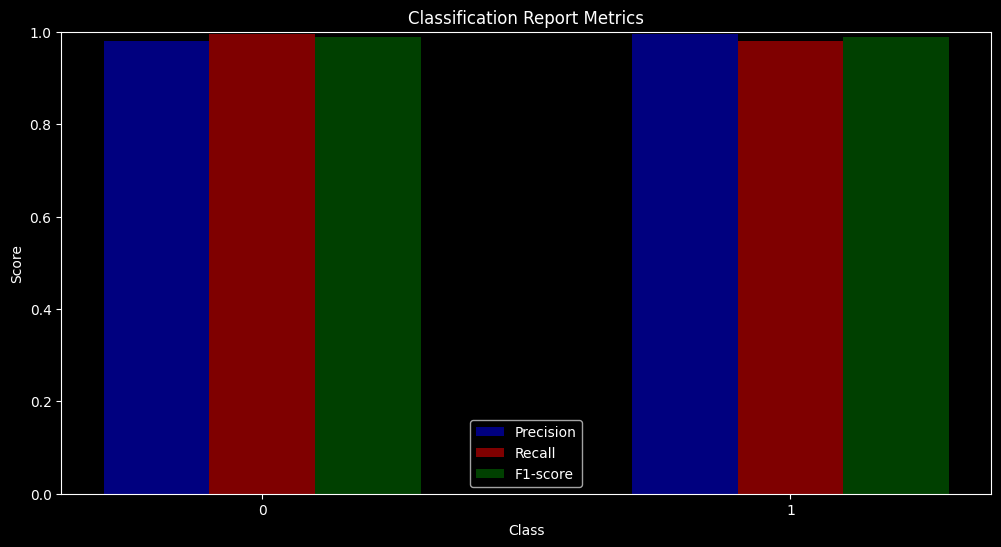

In [161]:
report = classification_report(y_test,y_pred_rf,output_dict=True)
# Parse values from the classification report
class_names = [str(x) for x in range(len(report) - 3)]  # Extract class names from report
metrics = ['precision', 'recall', 'f1-score', 'support']

# Initialize lists to store metric values
precision = []
recall = []
f1_score = []
support = []

for class_name in class_names:
    precision.append(report[class_name]['precision'])
    recall.append(report[class_name]['recall'])
    f1_score.append(report[class_name]['f1-score'])
    support.append(report[class_name]['support'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(class_names))

# Bar plot for precision
ax.bar(index, precision, bar_width, color='b', alpha=0.5, label='Precision')
# Bar plot for recall
ax.bar(index + bar_width, recall, bar_width, color='r', alpha=0.5, label='Recall')
# Bar plot for F1-score
ax.bar(index + 2*bar_width, f1_score, bar_width, color='g', alpha=0.5, label='F1-score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_ylim(0.0,1.0)
ax.set_title('Classification Report Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()

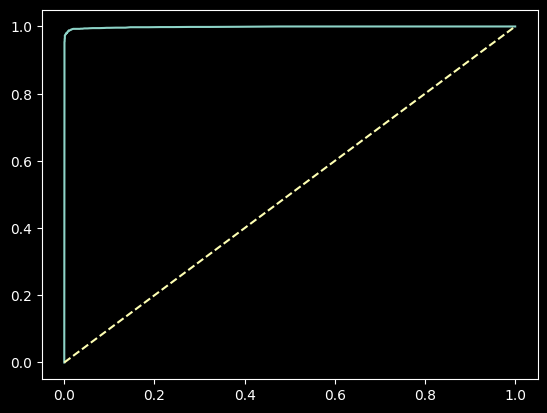

In [162]:
y_predproba = rf.predict_proba(x_test)
y_predproba_positive = y_predproba[:,1]

fpr,tpr,thresholds = roc_curve(y_test,y_predproba_positive)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--') #read as (0,0) and (1,1) 

In [163]:
cm = confusion_matrix(y_test, y_pred_rf) 

print("Confusion Matrix: logistic regression")
print(cm)

Confusion Matrix: logistic regression
[[2298   11]
 [  45 2218]]


In [164]:
# Categorize employees into different zones based on probability score
safe_zone = y_predproba < 0.2
low_risk_zone = (y_predproba >= 0.2) & (y_predproba < 0.6)
medium_risk_zone = (y_predproba >= 0.6) & (y_predproba < 0.9)
high_risk_zone = y_predproba >= 0.9

# Print the count of employees in each zone
print("Safe Zone:", np.sum(safe_zone))
print("Low Risk Zone:", np.sum(low_risk_zone))
print("Medium Risk Zone:", np.sum(medium_risk_zone))
print("High Risk Zone:", np.sum(high_risk_zone))

# Provide retention strategies for each zone
print("\nRetention Strategies:")
print("Safe Zone (Green): Implement employee recognition programs, provide opportunities for growth and development.")
print("Low Risk Zone (Yellow): Offer mentorship programs, conduct regular check-ins to address any concerns or challenges.")
print("Medium Risk Zone (Orange): Provide additional training and support, identify and address potential areas of dissatisfaction.")
print("High Risk Zone (Red): Conduct exit interviews to understand reasons for dissatisfaction, focus on immediate retention efforts.")

Safe Zone: 4350
Low Risk Zone: 270
Medium Risk Zone: 400
High Risk Zone: 4124

Retention Strategies:
Safe Zone (Green): Implement employee recognition programs, provide opportunities for growth and development.
Low Risk Zone (Yellow): Offer mentorship programs, conduct regular check-ins to address any concerns or challenges.
Medium Risk Zone (Orange): Provide additional training and support, identify and address potential areas of dissatisfaction.
High Risk Zone (Red): Conduct exit interviews to understand reasons for dissatisfaction, focus on immediate retention efforts.


### Random forest: performance evaluation - BEST MODEL
- on average, the logistic regression model performance was 99%. This is an impressive result and very close to perfect prediction,.  
- It is able to predict people who stay and leave with great accuracy and precision. It is slightly better at recalling people who stay at the company and slight more precise with people who left the company.  
- Lastly, since the model is well above the yellow dotted line, it is overall an impressively performing model. 

### Gradient boosting 

In [165]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
gb.fit(x_train, y_train)
y_pred = gb.predict(x_test)
results_gb = cross_val_score(gb,x,y,cv=kfolds)
results_gb.mean() #this is the average score of the model performance  

0.9731305546293209

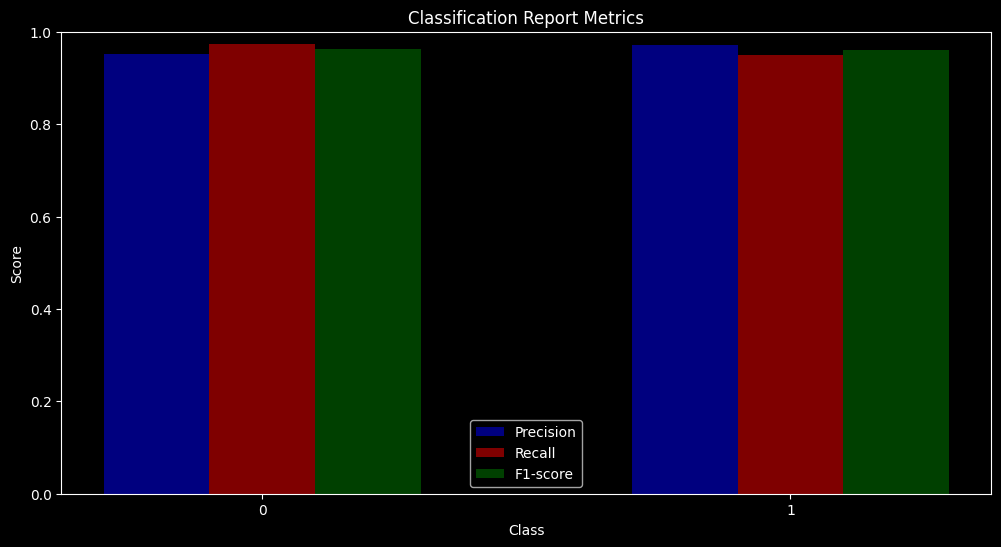

In [166]:
report = classification_report(y_test,y_pred,output_dict=True)
# Parse values from the classification report
class_names = [str(x) for x in range(len(report) - 3)]  # Extract class names from report
metrics = ['precision', 'recall', 'f1-score', 'support']

# Initialize lists to store metric values
precision = []
recall = []
f1_score = []
support = []

for class_name in class_names:
    precision.append(report[class_name]['precision'])
    recall.append(report[class_name]['recall'])
    f1_score.append(report[class_name]['f1-score'])
    support.append(report[class_name]['support'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))
bar_width = 0.2
index = np.arange(len(class_names))

# Bar plot for precision
ax.bar(index, precision, bar_width, color='b', alpha=0.5, label='Precision')
# Bar plot for recall
ax.bar(index + bar_width, recall, bar_width, color='r', alpha=0.5, label='Recall')
# Bar plot for F1-score
ax.bar(index + 2*bar_width, f1_score, bar_width, color='g', alpha=0.5, label='F1-score')

ax.set_xlabel('Class')
ax.set_ylabel('Score')
ax.set_ylim(0.0,1.0)
ax.set_title('Classification Report Metrics')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(class_names)
ax.legend()

plt.show()

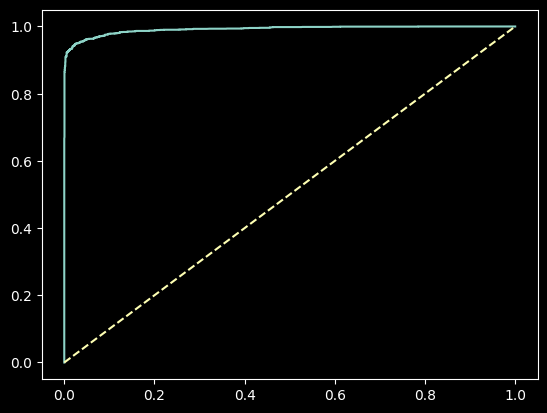

In [167]:
y_predproba = gb.predict_proba(x_test)
y_predproba_positive = y_predproba[:,1]

fpr,tpr,thresholds = roc_curve(y_test,y_predproba_positive)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
plt.plot([0,1],[0,1],linestyle='--') #read as (0,0) and (1,1) 

In [168]:
cm = confusion_matrix(y_test, y_pred) 

print("Confusion Matrix: logistic regression")
print(cm)

Confusion Matrix: logistic regression
[[2247   62]
 [ 115 2148]]


### Gradient boosting: performance evaluation
- on average, the logistic regression model performance was 97%. This is an impressive result and very close to perfect prediction.  
- Similar to random forest, tt is able to predict people who stay and leave with great accuracy and precision. It is slightly better at recalling people who stay at the company and slight more precise with people who left the company.  
- Lastly, since the model is well above the yellow dotted line, it is overall an impressively performing model. 